In [1]:
library(dplyr)
library(ggplot2)
library(RcppRoll)
library(sqldf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gsubfn

Loading required package: proto

Warning message in doTryCatch(return(expr), name, parentenv, handler):
“unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 6): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/3.6/Resources/modules/R_X11.so
  Reason: image not found”
Could not load tcltk.  Will use slower R code instead.

Loading required package: RSQLite



In [2]:
# to get this data:
# git clone https://github.com/chadwickbureau/retrosplits

df = read.csv('data/retrosplits/daybyday/playing-1999.csv')
df$season = 1999

for (season_ in 1999:2019)
{
    filename = paste0('data/retrosplits/daybyday/playing-', as.character(season_), '.csv')
    df_new = read.csv(filename)
    df_new$season = season_
    df = rbind(df, df_new)

}

In [3]:
# we later define "expected woba" using previous and following seasons' woba. 
# exclude players without a previous and next season (rookies, retirees)
# use inner join this onto the game-level data once "expected woba" is calculated and added to the dataset
player_years = df %>% select(person.key, season) %>% mutate(next_year = season+1, previous_year=season-1) %>% distinct()
player_years_to_keep = player_years %>% inner_join(player_years, by=c("season"="previous_year", "person.key"="person.key"))
player_years_to_keep = player_years_to_keep %>% inner_join(player_years, by=c("season"="next_year", "person.key"="person.key"))

In [4]:
# limit to just regular season, define 1B events
df = df %>% filter(season.phase=='R')
df = df %>% mutate(B_1B = B_H - B_2B - B_3B - B_HR)

In [5]:
# define game number within the season. later we'll want to exclude the final five games from streak identification
game_nums = df %>% group_by(season, team.key) %>% distinct(game.date, game.key, team.key) %>% arrange(season, team.key, game.date) %>% 
    mutate(game_num = seq_along(game.date))

df = df %>% left_join(game_nums %>% ungroup() %>% select(game.key, team.key, game_num), by=c('game.key', 'team.key'))

# do this filter AFTER creating game numbers so the game number is still accurate
df = df %>% filter(team.key != 'COL', site.key != 'DEN02')

In [6]:
# create home/away flag by finding most common stadium for each team
home_stadiums = df %>% group_by(team.key, season) %>% count(site.key) %>% top_n(1)
df = df %>% left_join(home_stadiums, by=c('team.key', 'season'), 
                 suffix=c('', '_homeflag')) %>% 
    mutate(home_or_away = ifelse(site.key==site.key_homeflag, 'home', 'away'))

Selecting by n



In [7]:
# create component-level park effects
games = df %>% 
    group_by(team.key, opponent.key, season, site.key, game.date, game.number, home_or_away) %>% 
                summarise(B_HR=sum(B_HR), 
                         B_1B = sum(B_1B),
                         B_2B = sum(B_2B),
                         B_3B = sum(B_3B),
                         B_BB = (sum(B_BB) - sum(B_IBB)),
                         B_HP = sum(B_HP),
                         B_XI = sum(B_XI),
                         B_R = sum(B_R),
                         games = n_distinct(team.key, opponent.key, season, 
                                            site.key, game.date, game.number, 
                                            home_or_away)) %>%
                ungroup()

`summarise()` regrouping output by 'team.key', 'opponent.key', 'season', 'site.key', 'game.date', 'game.number' (override with `.groups` argument)



In [8]:
#calculate three-year park effects
#shortcut to do this: create next year and previous year dataframes (season -= and += 1)
#concatenate those onto the main dataframe. now season=2003 will include 2002, 2003, and 2004. all three seasons in one.

# i think we'll need this to prevent duplicates later when joining things
games = games %>% mutate(actual_season=season)

next_year_games = games %>% mutate(season = season + 1)
previous_year_games = games %>% mutate(season = season - 1)

dim(games)
games = rbind(games, next_year_games)
games = rbind(games, previous_year_games)
dim(games)

games %>% filter(season==2002, team.key=='ANA') %>% dim()

[1] 96926    17

[1] 290778     17

[1] 483  17

In [9]:
games = games %>% 
    group_by(team.key, opponent.key, season, site.key, game.date, game.number, home_or_away) %>% 
                    summarise(B_HR=sum(B_HR), 
                             B_1B = sum(B_1B),
                             B_2B = sum(B_2B),
                             B_3B = sum(B_3B),
                             B_BB = sum(B_BB),
                             B_HP = sum(B_HP),
                             B_XI = sum(B_XI),
                             B_R = sum(B_R),
                             games = n_distinct(team.key, opponent.key, season, 
                                                site.key, game.date, game.number, 
                                                home_or_away)) %>%
                    ungroup()

`summarise()` regrouping output by 'team.key', 'opponent.key', 'season', 'site.key', 'game.date', 'game.number' (override with `.groups` argument)



In [10]:
home = games %>% filter(home_or_away=='home') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number", "season"="season"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR=(sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                         games=sum(games)
                ) %>% ungroup()


away = games %>% filter(home_or_away=='away') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR=(sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                         games=sum(games)
                ) %>% ungroup()


park_effects = home %>% left_join(away, by=c('team.key', 'season'), suffix=c('', '_road')) %>%
    mutate(
      B_HR = B_HR/B_HR_road, 
      B_1B = B_1B/B_1B_road,
      B_2B = B_2B/B_2B_road,
      B_3B = B_3B/B_3B_road,
      B_BB = B_BB/B_BB_road,
      B_HP = B_HP/B_HP_road,
      B_R = B_R/B_R_road
    )

# connect park effects with their site.key
#park_effects = park_effects %>% left_join(home_stadiums, by=c('team.key', 'season')) %>%
#    select(season, site.key, team.key, B_R, B_HR, B_1B,
#          B_2B, B_3B, B_HP, B_XI, B_BB)

`summarise()` regrouping output by 'season' (override with `.groups` argument)

`summarise()` regrouping output by 'season' (override with `.groups` argument)



In [11]:
# park-adjust all events
df = df %>% left_join(park_effects, by=c('season', 'team.key'), suffix = c("", "_parkfactor"))

df = df %>% mutate(
     B_HR = B_HR / B_HR_parkfactor,
     B_1B = B_1B/B_1B_parkfactor,
     B_2B = B_2B/B_2B_parkfactor,
     B_3B = B_3B/B_3B_parkfactor,
     B_BB = B_BB/B_BB_parkfactor,
     B_HP = B_HP/B_HP_parkfactor,
     B_XI = B_XI/B_XI_parkfactor,
     B_R = B_R/B_R_parkfactor,
)

In [12]:
park_effects %>% filter(season==2010) %>% arrange(-B_R)

season,team.key,B_HR,B_1B,B_2B,B_3B,B_BB,B_HP,B_XI,B_R,games,B_HR_road,B_1B_road,B_2B_road,B_3B_road,B_BB_road,B_HP_road,B_XI_road,B_R_road,games_road
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2010,TEX,1.2800830,1.0414600,1.1082090,1.3809524,1.0321199,1.2727273,1,1.1862934,243,1.983539,11.61317,3.308642,0.2592593,5.765432,0.5432099,1,8.526749,729
2010,BOS,0.9062162,1.0297664,1.2988008,0.9144947,0.9702322,1.1104136,1,1.1149362,243,2.375000,11.43333,3.491667,0.3375000,6.850000,0.7375000,1,9.279167,720
2010,ARI,1.0450450,0.9585913,1.1405089,1.7026604,0.9121582,1.0623306,1,1.1004356,243,2.055556,11.21759,3.254630,0.3287037,6.189815,0.5694444,1,8.384259,648
2010,CHN,1.0217575,1.0494997,0.9969781,1.2541866,1.0279472,0.9344920,1,1.0912515,242,1.892704,11.20172,3.386266,0.3261803,6.090129,0.7296137,1,8.236052,699
2010,NYA,1.3000000,1.0003522,0.9364162,0.6818182,1.0266344,1.0962567,1,1.0786122,243,2.098765,11.68313,3.559671,0.3621399,6.798354,0.7695473,1,9.370370,729
2010,CHA,1.3073299,0.9354493,0.9656249,0.7474141,1.1738977,1.0110308,1,1.0598865,243,1.725000,12.61250,3.362500,0.3083333,5.104167,0.7041667,1,8.545833,720
2010,BAL,1.1916168,1.0551370,1.0240437,0.8181818,0.9935484,1.0547945,1,1.0441570,243,2.061728,12.01646,3.765432,0.3168724,5.740741,0.6008230,1,9.226337,729
2010,TOR,1.1671089,0.9498336,1.0658480,1.3102941,0.9956587,0.9949422,1,1.0414933,240,2.209877,11.43621,3.748971,0.2798354,6.185185,0.7119342,1,9.197531,729
2010,KCA,0.7905258,1.0867262,1.0775486,1.6460905,1.0304433,1.1298765,1,1.0388023,243,2.045833,12.08750,3.479167,0.3500000,5.866667,0.5208333,1,9.091667,720


In [13]:
df = df %>% mutate(game.date = as.Date(game.date))

# Hot/cold streak definition

* Defined a hot / cold wOBA threshold 
* Rolling wOBA over five-game periods (so first or last five of the year cant be considered)
* Must have at least 20 PA in the five game stretch to be considered
* Thresholds defined as groups where 5 percent of league is hot, 5 is cold for a given 5 game stretch
* Roughly this means .525 woba for hot, .195 for cold 



TODO: make sure streaks don't count if a player missed a game in the middle. 

In [14]:
# define woba numerator and denominator to get N-game woba
# weights by year https://www.fangraphs.com/guts.aspx?type=cn
df = df %>% mutate(
    woba_numerator = 0.9*B_1B + 1.24*B_2B + 1.56*B_3B + 1.95*B_HR + 0.72*(B_BB - B_IBB) + 0.75*B_HP +  0.92*B_XI, # the book's weights
    woba_denominator = B_PA,
    game_woba = woba_numerator / woba_denominator)

In [15]:
# SQL query to create players' expected woba
# expected woba: a player's woba from the current, previous, and following season, omitting the player's past 5 games (inclusive of the current game)
player_woba = sqldf('
      select 
        df1."person.key",
        df1.season,
        df1.game_num,
        SUM(coalesce(df2.woba_numerator, 0)) season_woba_num,
        SUM(coalesce(df2.woba_denominator, 0)) season_woba_denom,
        sum(coalesce(df2.woba_numerator, 0))/sum(coalesce(df2.woba_denominator, 0)) expected_woba,
        sum(df2.B_PA) season_pa
      from
        df AS df1
      left join
        (select "person.key", season, game_num, SUM(coalesce(woba_numerator, 0)) woba_numerator,
    SUM(coalesce(woba_denominator, 0)) woba_denominator, sum(B_PA) B_PA from df group by 1,2,3) AS df2
      ON
        df1."person.key" = df2."person.key"
      AND
        df1.season <= df2.season + 1
      AND
        df1.season >= df2.season - 1
      AND
        (
            (df1.season*1000 + df1.game_num) <= (df2.season*1000 + df2.game_num -7)
        OR
            (df1.season*1000 + df1.game_num) > (df2.season*1000 + df2.game_num)
        )
      GROUP BY df1."person.key", df1.season, df1.game_num
')

In [16]:
player_woba %>% filter(season_pa>50) %>% arrange(-expected_woba) %>% head(15)

,person.key,season,game_num,season_woba_num,season_woba_denom,expected_woba,season_pa
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
1,marte001,1999,20,2161.412,3618,0.5974052,3618
2,marte001,1999,156,2174.358,3642,0.5970230,3642
3,marte001,1999,88,2164.248,3630,0.5962116,3630
4,marte001,1999,67,2161.390,3626,0.5960811,3626
5,marte001,1999,157,2179.402,3658,0.5957905,3658
6,bondb001,2001,2,1037.178,1742,0.5953950,1742
7,marte001,1999,89,2158.729,3626,0.5953473,3626
8,bondb001,2001,1,1033.402,1737,0.5949350,1737
9,marte001,1999,21,2154.680,3622,0.5948867,3622


In [17]:
df = df %>% left_join(player_woba,by=c('season', 'person.key', 'game_num'))

# remove these seasons. no future/past season available for calculating their expected woba values
df = df %>% filter(season > 1999, season < 2019)

dim(df)
# remove players we can't calculate an expected woba for 
df = df %>% inner_join(player_years_to_keep, by=c("person.key", "season"), suffixes=c("", "_ignore"))
dim(df)

[1] 1251409     206

[1] 1008701     212

In [18]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 5
num_games_post_streak = 5
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3,4,5,6,7))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it ahrder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, five_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, five_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  five_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Get Thresholds for Hot/Cold Streaks (top/bottom 5% of league in x-game rolling wOBA)

In [19]:
# get seasons' percentiles for woba thresholds
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  #woba_rolling_avg = mean(woba_rolling, na.rm=TRUE), 
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95))) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.1683759
0.5622036


In [20]:
# create is hot/cold flags
hot_threshold = .562
cold_threshold = .168
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

## Calculate Streak, Post-Streak, and Expected Value Summary Stats

In [21]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    #group_by(season) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
941,18677,411666,0.6276038,0.3732767,0.3737345,0.3717355,0.00194363,0.3756782,0.3717909,0.376459


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1116,19088,407940,0.1306141,0.3279639,0.3303407,0.3298392,0.00174157,0.3320822,0.3285991,0.3341104


In [22]:
# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_hot==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(-woba_rolling) %>% head(10)

# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_cold==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(woba_rolling) %>% head(10)

person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
carpm002,2018-07-21,20,1.0446908,0.2625587,0.3926502
carpm002,2018-07-21,22,0.9752546,0.4050841,0.3922359
martj008,2018-06-11,20,0.9344208,0.1895038,0.3863809
carpm002,2018-07-23,20,0.9296774,0.2468515,0.3933431
carpm002,2018-07-22,21,0.9265279,0.3034986,0.3943977
martj008,2018-06-10,20,0.9248903,0.3446960,0.3842611
carpm002,2018-07-20,22,0.9012599,0.4585039,0.3870538
nimmb001,2018-08-15,20,0.8891855,0.3926082,0.4134540
nimmb001,2018-08-28,22,0.8651762,0.5408291,0.4175847


person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
morak001,2018-05-06,22,0.00000000,0.27480492,0.3189429
gricr001,2018-04-08,20,0.00000000,0.37704694,0.3296167
gregd001,2018-05-10,23,0.03087632,0.07046833,0.3456251
deshd002,2018-07-10,20,0.03188263,0.06106841,0.2627652
gregd001,2018-05-11,22,0.03227979,0.13179524,0.3444414
polla001,2018-09-01,22,0.03479190,0.33414832,0.3393178
martl004,2018-05-22,21,0.03524430,0.26864983,0.2852723
calhk001,2018-09-15,21,0.03626581,0.16226315,0.3288449
owinc001,2018-05-25,21,0.03644865,0.32443648,0.2592994


In [23]:
# t-test for significance
test = df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)

t.test(test$mean_post_hot_woba, test$expected_woba)

test = df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)
t.test(test$mean_post_hot_woba, test$expected_woba)

`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = -0.40484, df = 22785, p-value = 0.6856
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002472881  0.001626235
sample estimates:
mean of x mean of y 
0.3713431 0.3717664 


`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = -2.7871, df = 21852, p-value = 0.005323
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0043656533 -0.0007605629
sample estimates:
mean of x mean of y 
0.3274515 0.3300146 


In [24]:
# regression for hot/cold effects
summary(lm(woba_rolling_future ~ expected_woba + is_hot + is_cold + site.key, 
           df %>% filter(!is.na(woba_rolling_future),
                        !is.na(is_hot))))


Call:
lm(formula = woba_rolling_future ~ expected_woba + is_hot + is_cold + 
    site.key, data = df %>% filter(!is.na(woba_rolling_future), 
    !is.na(is_hot)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98818 -0.08922 -0.00766  0.08036  2.51614 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.383e-02  1.189e-03  20.044  < 2e-16 ***
expected_woba  9.127e-01  2.549e-03 358.107  < 2e-16 ***
is_hot         6.511e-03  1.001e-03   6.506 7.73e-11 ***
is_cold        3.545e-04  9.827e-04   0.361  0.71829    
site.keyARL02  1.519e-03  1.210e-03   1.256  0.20921    
site.keyATL02  2.215e-03  1.231e-03   1.800  0.07184 .  
site.keyBAL12  1.254e-03  1.212e-03   1.035  0.30070    
site.keyBOS07  2.794e-04  1.190e-03   0.235  0.81437    
site.keyCHI11  1.431e-03  1.183e-03   1.209  0.22663    
site.keyCHI12  1.140e-04  1.198e-03   0.095  0.92422    
site.keyCIN08  6.159e-03  2.173e-03   2.835  0.00458 ** 
site.keyCLE08  1.105e-03  1.197e-

Warning message:
“Removed 88 rows containing non-finite values (stat_bin).”


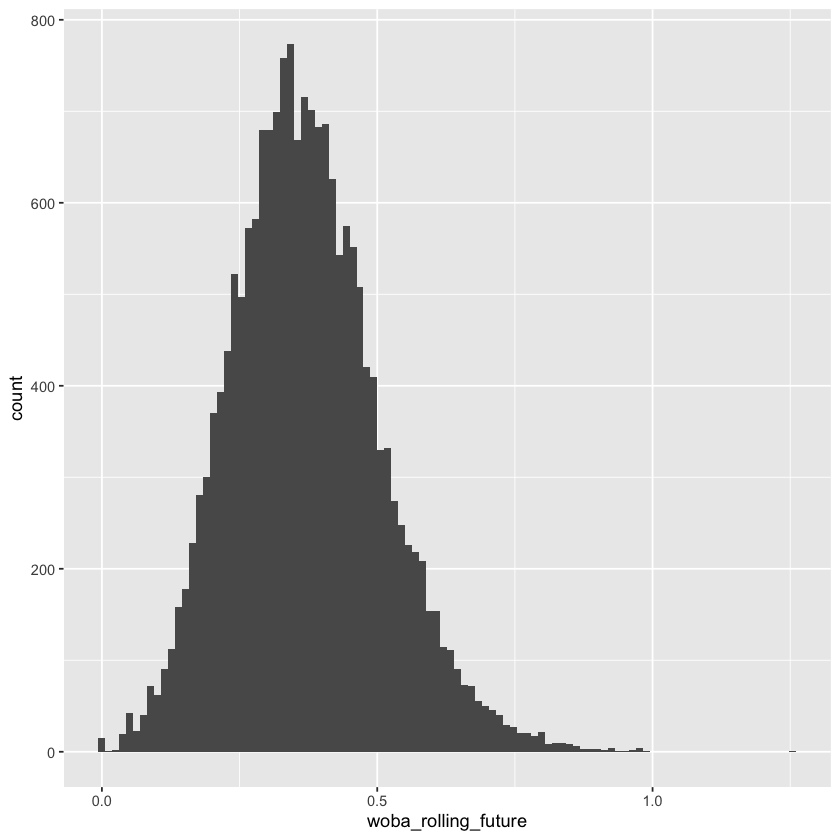

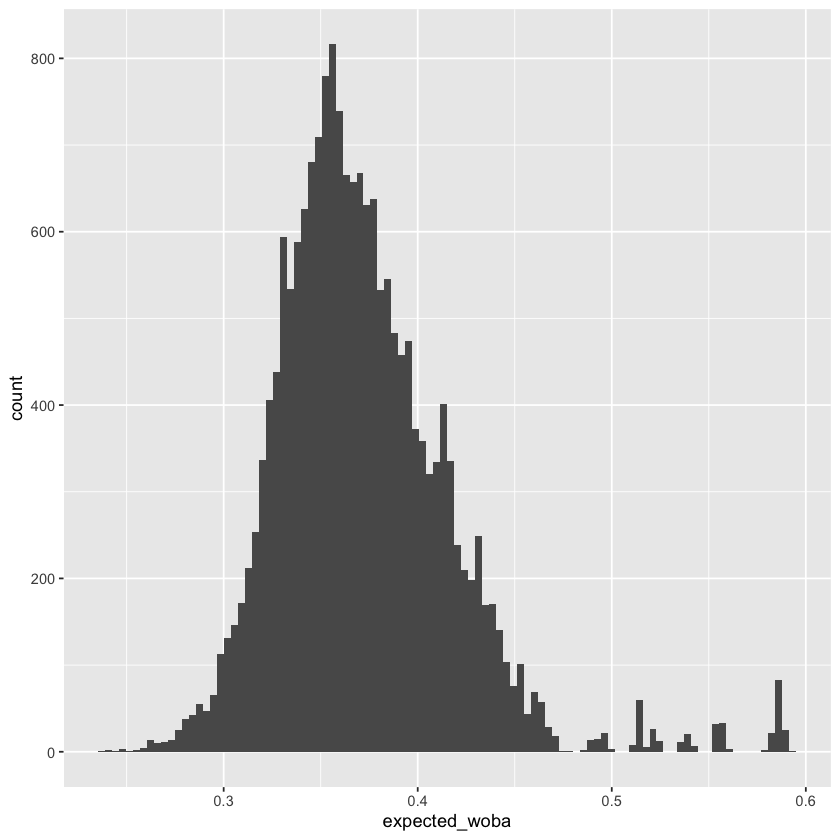

In [25]:
# inspect distributions of post-streak and expected woba
df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(woba_rolling_future) %>% ggplot(aes(x=woba_rolling_future)) + geom_histogram(bins=100)

df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(expected_woba) %>% ggplot(aes(x=expected_woba)) + geom_histogram(bins=100)

## Repeat the above steps for 7-game streaks

In [26]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 7
num_games_post_streak = 7
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3, 4, 5, 6, 7)) #list(c(1, 2, 3))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it ahrder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, seven_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, seven_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  seven_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 

In [27]:
# get seasons' quantiles for woba thresholds
#temp = df %>% group_by(season, person.key) %>% filter(sum(B_PA)>100) %>% ungroup()
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95), na.rm=TRUE)) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.1936534
0.5322388


In [28]:
# create is hot/cold flags
hot_threshold = .532
cold_threshold = .194
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

In [29]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
829,17592,540691,0.5884463,0.3797913,0.3789403,0.001734581,0.3815259,0.3780567,0.3774334


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1040,18205,543749,0.1608215,0.3279226,0.3267941,0.001515929,0.3294385,0.3264066,0.3276147


In [36]:
options("scipen"=100, "digits"=3)
summary(lm(woba_rolling_future ~ expected_woba + is_hot + is_cold + site.key, 
           df %>% filter(!is.na(woba_rolling_future),
                        !is.na(is_hot), season_pa>50)))


Call:
lm(formula = woba_rolling_future ~ expected_woba + is_hot + is_cold + 
    site.key, data = df %>% filter(!is.na(woba_rolling_future), 
    !is.na(is_hot), season_pa > 50))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4178 -0.0739 -0.0043  0.0687  2.5138 

Coefficients:
                Estimate Std. Error t value             Pr(>|t|)    
(Intercept)    0.0166337  0.0011467   14.51 < 0.0000000000000002 ***
expected_woba  0.9400574  0.0027085  347.08 < 0.0000000000000002 ***
is_hot         0.0052466  0.0008490    6.18      0.0000000006412 ***
is_cold       -0.0007384  0.0008244   -0.90              0.37039    
site.keyARL02 -0.0000218  0.0010229   -0.02              0.98297    
site.keyATL02  0.0015383  0.0010442    1.47              0.14071    
site.keyBAL12  0.0005042  0.0010242    0.49              0.62252    
site.keyBOS07 -0.0010090  0.0010028   -1.01              0.31430    
site.keyCHI11  0.0014522  0.0010030    1.45              0.14766    
site.keyCHI12 -0.0004